In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage
import os

In [ ]:
from sklearn.cluster import DBSCAN
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
import imageio
import os
import moviepy.editor as mvp
from pathlib import Path
from tqdm.notebook import tqdm

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2179072/45929032 bytes (4.7%)5275648/45929032 bytes (11.5%)8372224/45929032 bytes (18.2%)11452416/45929032 bytes (24.9%)14090240/45929032 bytes (30.7%)16818176/45929032 bytes (36.6%)19619840/45929032 bytes (42.7%)22577152/45929032 bytes (49.2%)25772032/45929032 bytes (56.1%)29065216/45929032 bytes (63.3%)32137216/45929032 bytes (70.0%)35463168/45929032 bytes (77.2%)

In [ ]:
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# load ct, normalize, rotate, 
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
# find the two lungs
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
# masks
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask #lungs without lesions
target_mask2 = ~bkgd # lungs with lesions
target_mask3 = ct_mask_small.astype(bool) #lesions only
SLICE=100
# get largest lesion using label
lab, nr_ = label(target_mask3)
lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
# get dimensions of one_big_lesion and find one_big_lesion is in left or right lung 
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
for i in [1,2]:
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
# pad each dimension to length multiple of 32 (needed for inpainting, maye not anymore)
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])

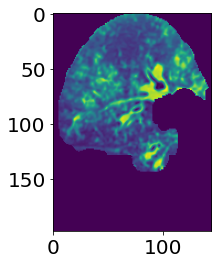

In [ ]:
plt.imshow(im)

## superpixels

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

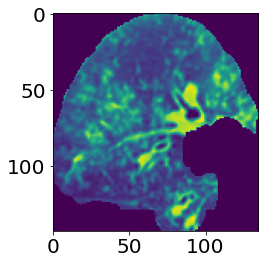

In [ ]:
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(np.expand_dims(im,-1)>0)
im2 = im[y_min: y_max, x_min: x_max]
plt.imshow(im2)

(-0.5, 134.5, 142.5, -0.5)

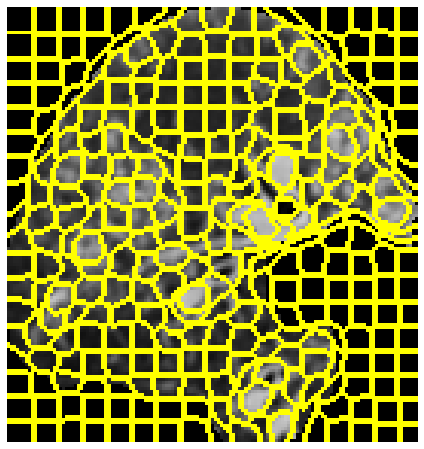

In [ ]:
numSegments = 300
plt.rcParams["lines.linewidth"] = .01
segments = slic(im2, n_segments = numSegments, sigma = 3, multichannel=False, compactness=.1)
# show the output of SLIC
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(im2, segments))
plt.axis("off")

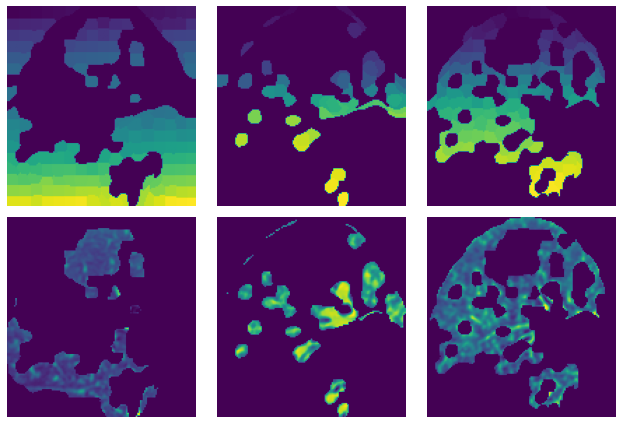

In [ ]:
import math
k=5
background = np.zeros_like(im2)
vessels = np.zeros_like(im2)
lesion_area = np.zeros_like(im2)
label_background, label_vessels, label_lession = 1, 1, 1,
for (i, segVal) in tqdm(enumerate(np.unique(segments))):
  # if i < k:continue
  # if i == k+10: break
  mask = np.zeros_like(im2)
  mask[segments == segVal] = 1
  clus = im2*mask
  median_intensity = np.median(clus[clus>0])
  yy,xx = np.where(mask==1)
  if median_intensity < .2 or math.isnan(median_intensity):
    background[yy,xx] = label_background
    label_background += 1
  elif median_intensity>.4:
    vessels[yy,xx] = label_vessels
    label_vessels += 1
  else:
    lesion_area[yy,xx] = label_lession
    label_lession += 1

fig, ax = plt.subplots(2,3, figsize=(9,6))
ax[0,0].imshow(background)
ax[0,1].imshow(vessels)
ax[0,2].imshow(lesion_area)
ax[1,0].imshow((background>0)*im2)
ax[1,1].imshow((vessels>0)*im2)
ax[1,2].imshow((lesion_area>0)*im2)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
lesion_area_merged1 = merge_labeled_clusters(lesion_area, DIST=20)

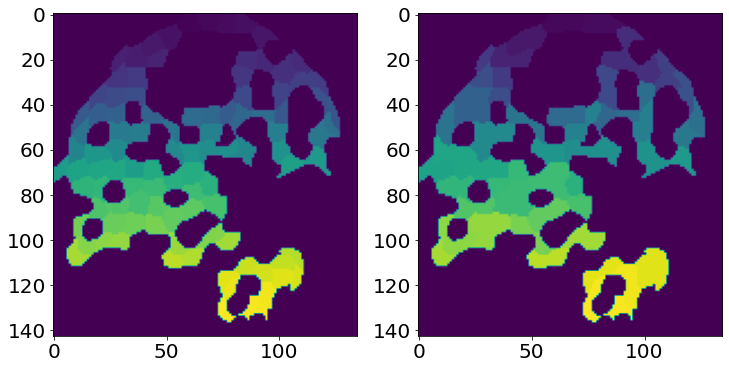

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(lesion_area)
ax[1].imshow(lesion_area_merged1)

In [ ]:
lesion_area_merged1 = merge_labeled_clusters(lesion_area, DIST=20)
lesion_area_merged = merge_labeled_clusters(lesion_area_merged1, DIST=40)
tgt_minis, tgt_minis_coords, tgt_minis_masks, tgt_minis_big, tgt_minis_coords_big, tgt_minis_masks_big = select_lesions_match_conditions(lesion_area_merged, target_img_covid, skip_index=0)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_minis, tgt_minis_coords, tgt_minis_masks, seed_method='max')

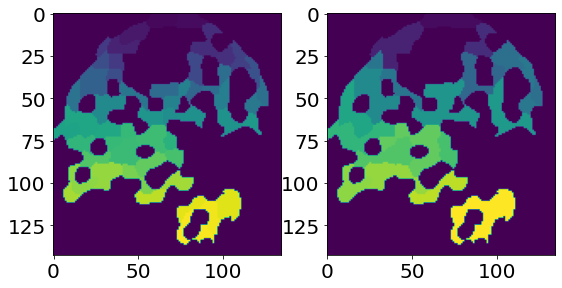

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(9,6))
ax[0].imshow(lesion_area_merged1)
ax[1].imshow(lesion_area_merged)

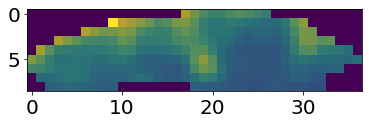

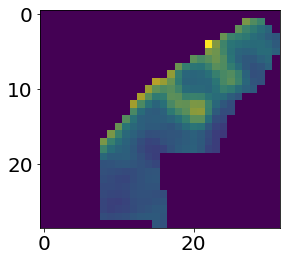

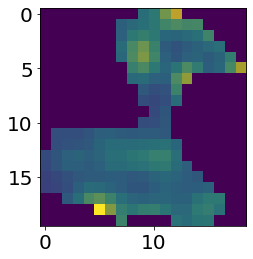

In [ ]:
for idx, (i,j) in enumerate(zip(targets,seeds)):
  if idx == 3: break
  plt.figure()
  plt.imshow(i[...,0])
  plt.imshow(j, alpha=.3)

## superpixels improvements
https://core.ac.uk/download/pdf/96762722.pdf

In [ ]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals


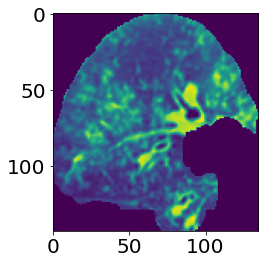

In [ ]:
plt.imshow(im2)

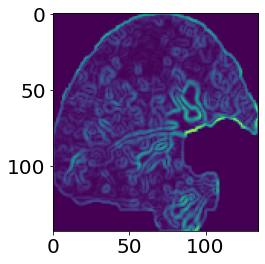

In [ ]:
#@vertical image gradient
from scipy.ndimage import sobel
sx = sobel(im2,axis=0, mode='constant')
sy = sobel(im2,axis=1, mode='constant')
im_grad = np.hypot(sx,sy)
plt.imshow(im_grad)

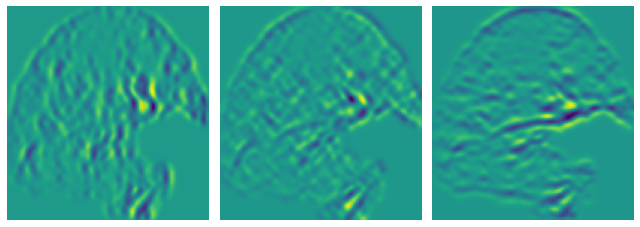

In [ ]:
# Hessian matrix
SIGMA=2
H_elems = hessian_matrix(im2, sigma=SIGMA, order='rc')
fig, ax = plt.subplots(1,np.shape(H_elems)[0], figsize=(9,6))
for i in range(np.shape(H_elems)[0]):
  ax[i].imshow(H_elems[i])
  ax[i].axis('off')
fig.tight_layout()

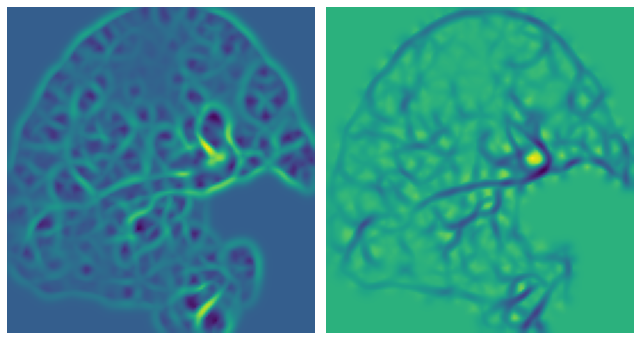

In [ ]:
# Hessian eigen-values
H_eigen = hessian_matrix_eigvals(H_elems)
fig, ax = plt.subplots(1,np.shape(H_eigen)[0], figsize=(9,6))
for i in range(np.shape(H_eigen)[0]):
  ax[i].imshow(H_eigen[i])
  ax[i].axis('off')
fig.tight_layout()

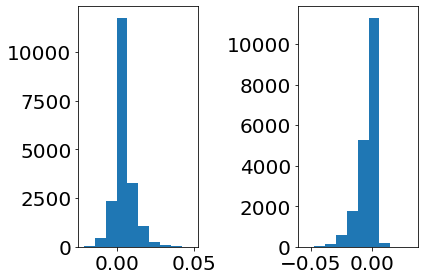

In [ ]:
H_eigen = hessian_matrix_eigvals(H_elems)
fig, ax = plt.subplots(1,np.shape(H_eigen)[0])
for i in range(np.shape(H_eigen)[0]):
  ax[i].hist(H_eigen[i].flatten())
  # ax[i].axis('off')
fig.tight_layout()

In [ ]:
# get ABS and ARG_MAX
H_eigen_abs = np.abs(H_eigen)
H_eigen_argmax = np.argmax(H_eigen_abs, 0)
print(np.shape(H_eigen_abs), np.shape(H_eigen_argmax))
print(np.unique(H_eigen_argmax))

(2, 143, 135) (143, 135)
[0 1]


In [ ]:
# get the value from the argmax
print(np.shape(H_eigen_argmax), np.shape(H_eigen_abs))
phi = np.ones_like(H_eigen_argmax).astype(float)
for i_row, row in enumerate(H_eigen_argmax):
  for i_col, element in enumerate(row):
    phi[i_row, i_col] = H_eigen_abs[element][i_row, i_col]

(143, 135) (2, 143, 135)


(143, 135)


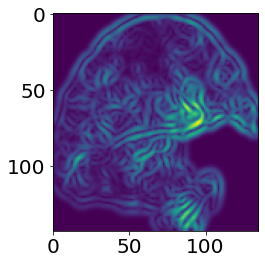

In [ ]:
print(np.shape(phi))
plt.imshow(phi)

In [ ]:
# get the sign from the argmax
print(np.shape(H_eigen_argmax), np.shape(H_eigen))
signs = np.ones_like(H_eigen_argmax).astype(float)
for i_row, row in enumerate(H_eigen_argmax):
  for i_col, element in enumerate(row):
    signs[i_row, i_col] = np.sign(H_eigen[element][i_row, i_col])

(143, 135) (2, 143, 135)


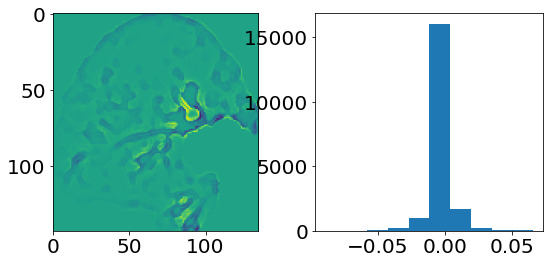

In [ ]:
phi_p = signs*(1-np.exp(-np.abs(phi*im_grad)))
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0].imshow(phi_p)
ax[1].hist(phi_p.flatten());

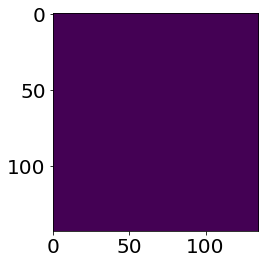

In [ ]:
plt.imshow(phi_p<-.1)

In [ ]:
numSegments = 300
segments = slic(phi_p, n_segments = numSegments, sigma = 3, multichannel=False, compactness=.1)
background, lesion_area, vessels = superpixels(phi_p, segments)
lesion_area_merged1 = merge_labeled_clusters(lesion_area, DIST=20)
lesion_area_merged = merge_labeled_clusters(lesion_area_merged1, DIST=40)
tgt_minis, tgt_minis_coords, tgt_minis_masks, tgt_minis_big, tgt_minis_coords_big, tgt_minis_masks_big = select_lesions_match_conditions(lesion_area_merged, target_img_covid, skip_index=0)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_minis, tgt_minis_coords, tgt_minis_masks, seed_method='max')

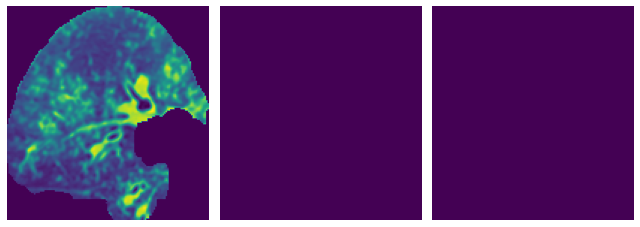

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9,4))
ax[0].imshow((background>0)*im2)
ax[1].imshow((vessels>0)*im2)
ax[2].imshow((lesion_area>0)*im2)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

## 3D

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [ ]:
im = copy(target_img_covid)
np.shape(im)

(198, 144, 101)

CPU times: user 8.38 s, sys: 10.9 ms, total: 8.39 s
Wall time: 8.39 s


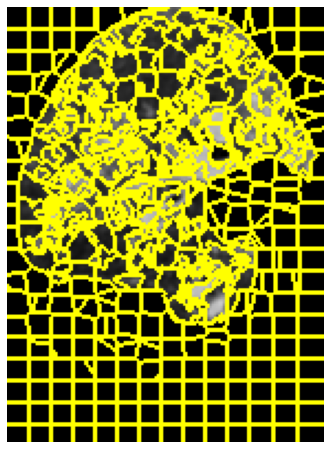

In [ ]:
%%time
numSegments = 3000
segments = slic(im, n_segments = numSegments, sigma = .2, multichannel=False, compactness=.1)
# show the output of SLIC
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(im[...,50], segments[...,50]))
plt.axis("off")

In [ ]:
import math
background, lesion_area, vessels = superpixels3D(im, segments, vessel_threshold=.5)

In [ ]:
np.shape(lesion_area)

(198, 144, 101)

In [ ]:
lesion_area_merged1 = merge_labeled_clusters3D2(lesion_area, DIST=20)

In [ ]:
lesion_area_merged1 = merge_labeled_clusters3D3(lesion_area, DIST=20)

ValueError: ignored

In [ ]:
type(lesion_area)

numpy.ndarray

In [ ]:
@jit(nopython=True)
def get_min():
  emp = []
  a1 = 10; a2 = 20; a3 = 30; a4 = 40
  aa = np.asarray([a1,a2,a3,a4])
  a = aa.min()
  # a = np.min((a1,a2,a3,a4))
  return emp

In [ ]:
from numba import jit

In [ ]:
@jit(nopython=True)
def get_min_max2(mask, LABEL=1):
  yy, xx, zz = np.where(mask == LABEL)
  y_max = np.max(yy); y_min = np.min(yy)
  x_max = np.max(xx); x_min = np.min(xx)
  z_max = np.max(zz); z_min = np.min(zz)
  return y_min, y_max, x_min, x_max, z_min, z_max

In [ ]:
@jit(nopython=True)
def get_min_max2(mask, LABEL=1):
  yy, xx, zz = np.where(mask == LABEL)
  y_max = yy.max(); y_min = yy.min()
  x_max = xx.max(); x_min = xx.min()
  z_max = zz.max(); z_min = zz.min()
  return y_min, y_max, x_min, x_max, z_min, z_max

In [ ]:
type(lesion_area)

numpy.ndarray

In [ ]:
@jit(nopython=True)
def dist_one_box_vs_all_boxes(mask, i, y_min, y_max, x_min, x_max, z_min, z_max, DIST=40):
    '''get distances between the corner points of one box containing one label and all possible pairs'''
    merge_pair = np.asarray([np.float64(x) for x in range(0)])
    merge_pair_dist = np.inf
    for j in np.unique(mask)[1:]:
        if i!=j:
            yy, xx, zz = np.where(mask == j)
            y_max_j = yy.max(); y_min_j = yy.min()
            x_max_j = xx.max(); x_min_j = xx.min()
            z_max_j = zz.max(); z_min_j = zz.min()
            # y_min_j, y_max_j, x_min_j, x_max_j,z_min_j, z_max_j = get_min_max2(mask==j)
            
            # get distances between all corners
            y11 = np.abs(y_min-y_min_j); y12 = np.abs(y_min-y_max_j); y21 = np.abs(y_max-y_min_j); y22 = np.abs(y_max-y_max_j)
            x11 = np.abs(x_min-x_min_j); x12 = np.abs(x_min-x_max_j); x21 = np.abs(x_max-x_min_j); x22 = np.abs(x_max-x_max_j)
            z11 = np.abs(z_min-z_min_j); z12 = np.abs(z_min-z_max_j); z21 = np.abs(z_max-z_min_j); z22 = np.abs(z_max-z_max_j)

            y_mindist = np.asarray([y11,y12,y21,y22]).min(); 
            x_mindist = np.asarray([x11,x12,x21,x22]).min(); 
            z_mindist = np.asarray([z11,z12,z21,z22]).min()
            
            hyp_mindist=np.sqrt(np.power(y_mindist,2) + np.power(x_mindist,2) + np.power(z_mindist,2))
    
            if np.less(y11, DIST) and np.less(y12, DIST) and np.less(y21, DIST) and np.less(y22, DIST) and np.less(x11, DIST) and np.less(x12, DIST) and np.less(x21, DIST) and np.less(x22, DIST) and np.less(z11, DIST) and np.less(z12, DIST) and np.less(z21, DIST) and np.less(z22, DIST) and np.less(hyp_mindist, merge_pair_dist): 

                merge_pair_dist = hyp_mindist 
                # print(f'merge {int(i),int(j)}, {hyp_mindist:.02f} {y_mindist}, {x_mindist}')
                # print(i, j, hyp_mindist, y_mindist, x_mindist)
                merge_pair = np.asarray([i, j, hyp_mindist])
    return merge_pair

In [ ]:
def merge_labeled_clusters3D3(mask, DIST=40):
    '''recursive function that clusters separated masks that are close to each other.
    We merge those masks which all corners are within a distance DIST along x and y axes'''
    pairs_to_merge = []
    for idx, i in tqdm(enumerate(np.unique(mask)[1:]), total=len(np.unique(mask)[1:])):
        # if idx < len(np.unique(mask)[1:])*.99: continue

        y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(mask==i)
        coords_four = [[y_min,x_min,z_min], [y_min,x_max,z_min], [y_max,x_min,z_min], [y_max,x_max,z_min],
                       [y_min,x_min,z_max], [y_min,x_max,z_max], [y_max,x_min,z_max], [y_max,x_max,z_max]]
        
        merge_pair = dist_one_box_vs_all_boxes(mask, i, y_min, y_max, x_min, x_max, z_min, z_max)
        pairs_to_merge.append(merge_pair)
        
    pairs_to_merge = list(filter(None, pairs_to_merge)) # remove empty pairs
    pairs_to_merge.sort(key=lambda tup: tup[2]) # sort pairs
    # get closest pairs of clusters (a cluster can only belong to its closest pair)
    clusters_used = []
    for i in pairs_to_merge:
        if i[0] not in clusters_used and i[1] not in clusters_used: 
            clusters_used.append(i[0])
            clusters_used.append(i[1])
    # merge clusters
    unique_replaced = np.unique(mask)
    for i in range(len(clusters_used)//2):
        unique_replaced[unique_replaced==clusters_used[i*2]]= clusters_used[i*2+1]
    mask_new = np.zeros_like(mask)
    for idx, i in enumerate(np.unique(mask)[1:]):
        mask_new[np.where(mask==i)] = unique_replaced[idx+1]
    if len(pairs_to_merge)!=0: #recursive
         mask_new = merge_labeled_clusters(mask_new,DIST=DIST)
    return mask_new

In [ ]:
def merge_labeled_clusters3D2(mask, DIST=40):
    '''recursive function that clusters separated masks that are close to each other.
    We merge those masks which all corners are within a distance DIST along x and y axes'''
    pairs_to_merge = []
    for idx, i in tqdm(enumerate(np.unique(mask)[1:]), total=len(np.unique(mask)[1:])):
        # if idx < len(np.unique(mask)[1:])*.99: continue

        y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(mask==i)
        coords_four = [[y_min,x_min,z_min], [y_min,x_max,z_min], [y_max,x_min,z_min], [y_max,x_max,z_min],
                       [y_min,x_min,z_max], [y_min,x_max,z_max], [y_max,x_min,z_max], [y_max,x_max,z_max]]
        merge_pair = []
        merge_pair_dist = np.inf
        # get distances between the corner points of one box containing one label and all possible pairs
        for idj, j in enumerate(np.unique(mask)[1:]):
            if i!=j:
                y_min_j, y_max_j, x_min_j, x_max_j,z_min_j, z_max_j = get_min_max(mask==j)
                coords_four_j = [[y_min_j,x_min_j,z_min_j], [y_min_j,x_max_j,z_min_j], [y_max_j,x_min_j,z_min_j], [y_max_j,x_max_j,z_min_j],
                                 [y_min_j,x_min_j,z_max_j], [y_min_j,x_max_j,z_max_j], [y_max_j,x_min_j,z_max_j], [y_max_j,x_max_j,z_max_j]]
                # get distances between all corners
                y11 = np.abs(y_min-y_min_j); y12 = np.abs(y_min-y_max_j); y21 = np.abs(y_max-y_min_j); y22 = np.abs(y_max-y_max_j)
                x11 = np.abs(x_min-x_min_j); x12 = np.abs(x_min-x_max_j); x21 = np.abs(x_max-x_min_j); x22 = np.abs(x_max-x_max_j)
                z11 = np.abs(z_min-z_min_j); z12 = np.abs(z_min-z_max_j); z21 = np.abs(z_max-z_min_j); z22 = np.abs(z_max-z_max_j)
                y_mindist = np.min([y11,y12,y21,y22]); x_mindist = np.min([x11,x12,x21,x22]); z_mindist = np.min([z11,z12,z21,z22])
                hyp_mindist=np.sqrt(y_mindist**2 + x_mindist**2 + z_mindist**2)
                if y11 < DIST and y12 < DIST and y21 < DIST and y22 < DIST and x11 < DIST and x12 < DIST and x21 < DIST and x22 < DIST and z11 < DIST and z12 < DIST and z21 < DIST and z22 < DIST and hyp_mindist < merge_pair_dist: 
                    merge_pair_dist = hyp_mindist 
                    # print(f'merge {int(i),int(j)}, {hyp_mindist:.02f} {y_mindist}, {x_mindist}')
                    merge_pair = (int(i),int(j),hyp_mindist)
        pairs_to_merge.append(merge_pair)
        
    pairs_to_merge = list(filter(None, pairs_to_merge)) # remove empty pairs
    pairs_to_merge.sort(key=lambda tup: tup[2]) # sort pairs
    # get closest pairs of clusters (a cluster can only belong to its closest pair)
    clusters_used = []
    for i in pairs_to_merge:
        if i[0] not in clusters_used and i[1] not in clusters_used: 
            clusters_used.append(i[0])
            clusters_used.append(i[1])
    # merge clusters
    unique_replaced = np.unique(mask)
    for i in range(len(clusters_used)//2):
        unique_replaced[unique_replaced==clusters_used[i*2]]= clusters_used[i*2+1]
    mask_new = np.zeros_like(mask)
    for idx, i in enumerate(np.unique(mask)[1:]):
        mask_new[np.where(mask==i)] = unique_replaced[idx+1]
    if len(pairs_to_merge)!=0: #recursive
         mask_new = merge_labeled_clusters(mask_new,DIST=DIST)
    return mask_new

In [ ]:
coords_cubes = []
coords_y, coords_x, coords_z = [], [], []
coords_y_dic = {}
for idx, i in tqdm(enumerate(np.unique(lesion_area)[1:]), total=len(np.unique(lesion_area)[1:])):
  yA1, yA2, xA1, xA2, zA1, zA2 = get_min_max(lesion_area==i)
  coords_cube = [[yA1,xA1,zA1], [yA1,xA2,zA1], [yA2,xA1,zA1], [yA2,xA2,zA1], [yA1,xA1,zA2], [yA1,xA2,zA2], [yA2,xA1,zA2], [yA2,xA2,zA2]]
  coords_cubes.append(coords_cube)
  coords_y.extend([yA1, yA2])
  coords_y_dic[idx]=(yA1, yA2)

In [ ]:
coords_y_dic.items()

dict_items([(0, (0, 13)), (1, (0, 12)), (2, (0, 12)), (3, (0, 14)), (4, (0, 11)), (5, (0, 12)), (6, (0, 12)), (7, (0, 5)), (8, (0, 11)), (9, (0, 5)), (10, (0, 8)), (11, (0, 12)), (12, (0, 4)), (13, (0, 11)), (14, (0, 13)), (15, (0, 11)), (16, (0, 3)), (17, (0, 8)), (18, (0, 12)), (19, (0, 10)), (20, (0, 13)), (21, (0, 14)), (22, (0, 13)), (23, (0, 11)), (24, (0, 14)), (25, (0, 16)), (26, (0, 14)), (27, (1, 22)), (28, (1, 12)), (29, (1, 12)), (30, (1, 17)), (31, (2, 21)), (32, (2, 16)), (33, (2, 16)), (34, (2, 25)), (35, (2, 16)), (36, (3, 15)), (37, (3, 17)), (38, (3, 16)), (39, (3, 19)), (40, (3, 22)), (41, (3, 15)), (42, (4, 17)), (43, (4, 19)), (44, (4, 42)), (45, (4, 19)), (46, (5, 24)), (47, (5, 19)), (48, (5, 21)), (49, (5, 23)), (50, (5, 27)), (51, (5, 20)), (52, (5, 19)), (53, (6, 22)), (54, (6, 21)), (55, (6, 21)), (56, (7, 22)), (57, (7, 22)), (58, (7, 28)), (59, (7, 24)), (60, (7, 33)), (61, (8, 20)), (62, (8, 19)), (63, (8, 25)), (64, (8, 20)), (65, (8, 24)), (66, (8, 19)),

In [ ]:
coords_y[:20]

[0, 13, 0, 12, 0, 12, 0, 14, 0, 11, 0, 12, 0, 12, 0, 5, 0, 11, 0, 5]

In [ ]:
coords_y_dic_sorted1 = dict(sorted(coords_y_dic.items(), key=lambda coords_y_dic: coords_y_dic[1][1]))
coords_y_dic_sorted1

In [ ]:
coords_y_dic.items()

dict_items([(0, [0, 13]), (1, [0, 12]), (2, [0, 12]), (3, [0, 14]), (4, [0, 11]), (5, [0, 12]), (6, [0, 12]), (7, [0, 5]), (8, [0, 11]), (9, [0, 5]), (10, [0, 8]), (11, [0, 12]), (12, [0, 4]), (13, [0, 11]), (14, [0, 13]), (15, [0, 11]), (16, [0, 3]), (17, [0, 8]), (18, [0, 12]), (19, [0, 10]), (20, [0, 13]), (21, [0, 14]), (22, [0, 13]), (23, [0, 11]), (24, [0, 14]), (25, [0, 16]), (26, [0, 14]), (27, [1, 22]), (28, [1, 12]), (29, [1, 12]), (30, [1, 17]), (31, [2, 21]), (32, [2, 16]), (33, [2, 16]), (34, [2, 25]), (35, [2, 16]), (36, [3, 15]), (37, [3, 17]), (38, [3, 16]), (39, [3, 19]), (40, [3, 22]), (41, [3, 15]), (42, [4, 17]), (43, [4, 19]), (44, [4, 42]), (45, [4, 19]), (46, [5, 24]), (47, [5, 19]), (48, [5, 21]), (49, [5, 23]), (50, [5, 27]), (51, [5, 20]), (52, [5, 19]), (53, [6, 22]), (54, [6, 21]), (55, [6, 21]), (56, [7, 22]), (57, [7, 22]), (58, [7, 28]), (59, [7, 24]), (60, [7, 33]), (61, [8, 20]), (62, [8, 19]), (63, [8, 25]), (64, [8, 20]), (65, [8, 24]), (66, [8, 19]),

In [ ]:
coords_y_dic_sorted2.items()

dict_items([(0, [0, 13]), (1, [0, 12]), (2, [0, 12]), (3, [0, 14]), (4, [0, 11]), (5, [0, 12]), (6, [0, 12]), (7, [0, 5]), (8, [0, 11]), (9, [0, 5]), (10, [0, 8]), (11, [0, 12]), (12, [0, 4]), (13, [0, 11]), (14, [0, 13]), (15, [0, 11]), (16, [0, 3]), (17, [0, 8]), (18, [0, 12]), (19, [0, 10]), (20, [0, 13]), (21, [0, 14]), (22, [0, 13]), (23, [0, 11]), (24, [0, 14]), (25, [0, 16]), (26, [0, 14]), (27, [1, 22]), (28, [1, 12]), (29, [1, 12]), (30, [1, 17]), (31, [2, 21]), (32, [2, 16]), (33, [2, 16]), (34, [2, 25]), (35, [2, 16]), (36, [3, 15]), (37, [3, 17]), (38, [3, 16]), (39, [3, 19]), (40, [3, 22]), (41, [3, 15]), (42, [4, 17]), (43, [4, 19]), (44, [4, 42]), (45, [4, 19]), (46, [5, 24]), (47, [5, 19]), (48, [5, 21]), (49, [5, 23]), (50, [5, 27]), (51, [5, 20]), (52, [5, 19]), (53, [6, 22]), (54, [6, 21]), (55, [6, 21]), (56, [7, 22]), (57, [7, 22]), (58, [7, 28]), (59, [7, 24]), (60, [7, 33]), (61, [8, 20]), (62, [8, 19]), (63, [8, 25]), (64, [8, 20]), (65, [8, 24]), (66, [8, 19]),

In [ ]:
coords_y_dic_sorted2 = sorted(coords_y_dic.items(), key=lambda coords_y_dic: coords_y_dic[1][0])
coords_y_dic_sorted2

In [ ]:
coords3D = just_coords3D(lesion_area, DIST=20)
np.shape(coords3D)

(544, 8, 3)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(coords3D1, method='complete', metric=)

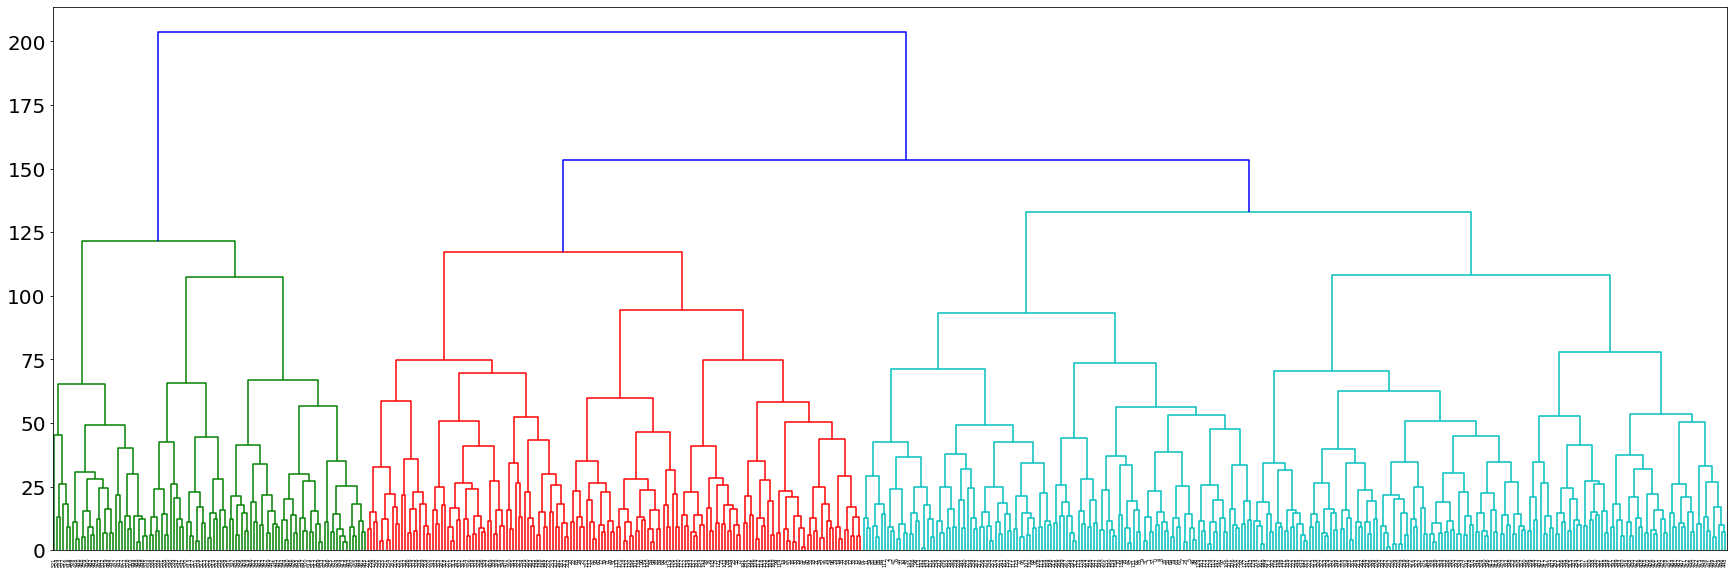

In [ ]:
coords3D1 = [i[0] for i in coords3D]
np.shape(coords3D1)
plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()

In [ ]:
def superpixels3D(im2, segments, background_threshold=.2, vessel_threshold=.4):
  '''1) segment all image using superpixels. 
  2) Then, classify each superpixel into background, vessel or lession according
  to its median intensity'''
  background = np.zeros_like(im2)
  vessels = np.zeros_like(im2)
  lesion_area = np.zeros_like(im2)
  label_background, label_vessels, label_lession = 1, 1, 1,
  for (i, segVal) in tqdm(enumerate(np.unique(segments)),total=len(np.unique(segments))):
    mask = np.zeros_like(im2)
    mask[segments == segVal] = 1
    clus = im2*mask
    median_intensity = np.median(clus[clus>0])
    yy,xx,zz = np.where(mask==1)
    if median_intensity < background_threshold or math.isnan(median_intensity):
      background[yy,xx,zz] = label_background
      label_background += 1
    elif median_intensity > vessel_threshold:
      vessels[yy,xx,zz] = label_vessels
      label_vessels += 1
    else:
      lesion_area[yy,xx,zz] = label_lession
      label_lession += 1
  return background, lesion_area, vessels

In [ ]:
def just_coords3D(mask, DIST=40):
    '''recursive function that clusters separated masks that are close to each other.
    We merge those masks which all corners are within a distance DIST along x and y axes'''
    coords3Ds = []
    for idx, i in tqdm(enumerate(np.unique(mask)[1:]), total=len(np.unique(mask)[1:])):
        y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(mask==i)
        coords3Ds.append([[y_min,x_min,z_min], [y_min,x_max,z_min], [y_max,x_min,z_min], [y_max,x_max,z_min],
                       [y_min,x_min,z_max], [y_min,x_max,z_max], [y_max,x_min,z_max], [y_max,x_max,z_max]])
    return coords3Ds

In [ ]:
def merge_labeled_clusters3D(mask, DIST=40):
    '''recursive function that clusters separated masks that are close to each other.
    We merge those masks which all corners are within a distance DIST along x and y axes'''
    pairs_to_merge = []
    for idx, i in tqdm(enumerate(np.unique(mask)[1:]), total=len(np.unique(mask)[1:])):
        y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(mask==i)
        coords_four = [[y_min,x_min,z_min], [y_min,x_max,z_min], [y_max,x_min,z_min], [y_max,x_max,z_min],
                       [y_min,x_min,z_max], [y_min,x_max,z_max], [y_max,x_min,z_max], [y_max,x_max,z_max]]
        merge_pair = []
        merge_pair_dist = np.inf
        # get distances between the corner points of one box containing one label and all possible pairs
        for idj, j in enumerate(np.unique(mask)[1:]):
            if i!=j:
                y_min_j, y_max_j, x_min_j, x_max_j,z_min_j, z_max_j = get_min_max(mask==j)
                coords_four_j = [[y_min_j,x_min_j,z_min_j], [y_min_j,x_max_j,z_min_j], [y_max_j,x_min_j,z_min_j], [y_max_j,x_max_j,z_min_j],
                                 [y_min_j,x_min_j,z_max_j], [y_min_j,x_max_j,z_max_j], [y_max_j,x_min_j,z_max_j], [y_max_j,x_max_j,z_max_j]]
                # get distances between all corners
                y11 = np.abs(y_min-y_min_j); y12 = np.abs(y_min-y_max_j); y21 = np.abs(y_max-y_min_j); y22 = np.abs(y_max-y_max_j)
                x11 = np.abs(x_min-x_min_j); x12 = np.abs(x_min-x_max_j); x21 = np.abs(x_max-x_min_j); x22 = np.abs(x_max-x_max_j)
                z11 = np.abs(z_min-z_min_j); z12 = np.abs(z_min-z_max_j); z21 = np.abs(z_max-z_min_j); z22 = np.abs(z_max-z_max_j)
                y_mindist = np.min([y11,y12,y21,y22]); x_mindist = np.min([x11,x12,x21,x22]); z_mindist = np.min([z11,z12,z21,z22])
                hyp_mindist=np.sqrt(y_mindist**2 + x_mindist**2 + z_mindist**2)
                if y11 < DIST and y12 < DIST and y21 < DIST and y22 < DIST and x11 < DIST and x12 < DIST and x21 < DIST and x22 < DIST and z11 < DIST and z12 < DIST and z21 < DIST and z22 < DIST and hyp_mindist < merge_pair_dist: 
                    merge_pair_dist = hyp_mindist 
                    # print(f'merge {int(i),int(j)}, {hyp_mindist:.02f} {y_mindist}, {x_mindist}')
                    merge_pair = (int(i),int(j),hyp_mindist)
        pairs_to_merge.append(merge_pair)
        
    pairs_to_merge = list(filter(None, pairs_to_merge)) # remove empty pairs
    pairs_to_merge.sort(key=lambda tup: tup[2]) # sort pairs
    # get closest pairs of clusters (a cluster can only belong to its closest pair)
    clusters_used = []
    for i in pairs_to_merge:
        if i[0] not in clusters_used and i[1] not in clusters_used: 
            clusters_used.append(i[0])
            clusters_used.append(i[1])
    # merge clusters
    unique_replaced = np.unique(mask)
    for i in range(len(clusters_used)//2):
        unique_replaced[unique_replaced==clusters_used[i*2]]= clusters_used[i*2+1]
    mask_new = np.zeros_like(mask)
    for idx, i in enumerate(np.unique(mask)[1:]):
        mask_new[np.where(mask==i)] = unique_replaced[idx+1]
    if len(pairs_to_merge)!=0: #recursive
         mask_new = merge_labeled_clusters(mask_new,DIST=DIST)
    return mask_new

## cluster lesions


In [ ]:
#@title clustering one slice {vertical-output: true}
# segment with intensity thresholding
im = copy(target_img_covid[...,SLICE])
im_r = im.reshape(im.shape[0]*im.shape[1])
for i in range(im_r.shape[0]):
    im_r[i] = np.floor(im_r[i]*5)
im2 = im_r.reshape(im.shape[0],im.shape[1])

# clustering
mask_lesion2 = im2==2
mask_lesion1 = im2==1
mask_lesion = mask_lesion1 + mask_lesion2
small_lesions, labels  = apply_dbscan_to_mask(mask_lesion, skip_low_intensity=2)
# select_lesions_match_conditions and make or add to the targets and seeds lists
tgt_small, tgt_coords_small, tgt_masks_small, tgt_big, tgt_coords_big, tgt_masks_big =  select_lesions_match_conditions(small_lesions, target_img_covid, max_size=1000)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small, tgt_coords_small, tgt_masks_small)
print(f'lesions = {len(tgt_small)}, big lesions = {len(tgt_big)}')
# select lesions and add to lists from smaller lesions
smaller_merged_all = []
for idx_, (mask_small, coords_big_) in enumerate(zip(tgt_masks_big, tgt_coords_big)):
  # if idx_ >=1:break
  # grid search DBSCAN
  eps_sel, samp_sel = grid_search_DBSCAN_params(mask_small)
  smaller_lesions, labels = apply_dbscan_to_mask(mask_small, eps=eps_sel, min_samples=samp_sel)
  # use label to get not clustered areas 
  skip_low_intensity = 2
  last_idx = np.max(np.unique(labels))+skip_low_intensity
  smaller_multi = label_mask_and_add_to_clusters(smaller_lesions, last_idx)
  # merge labeled clusters
  smaller_merged = merge_labeled_clusters(smaller_multi, DIST=40)
  smaller_merged_orig_size = np.zeros_like(im)
  smaller_merged_orig_size[coords_big_[0]:coords_big_[1],coords_big_[2]:coords_big_[3]] = smaller_merged
  # select_lesions_match_conditions
  tgt_small2, tgt_coords_small2, tgt_masks_small2, tgt_big2, tgt_coords_big2, tgt_masks_big2 =  select_lesions_match_conditions(smaller_merged_orig_size, target_img_covid, max_size=1000)
  # make or add to the lists of targets and seeds
  targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_small2, tgt_coords_small2, tgt_masks_small2, init_lists=False, targets=targets, seeds=seeds, masks=masks, coords=coords)
  print(f'total lesions = {len(targets)}')
  smaller_merged_all.append(smaller_merged)

lesions = 7, big lesions = 2



total lesions = 10



total lesions = 16


(18, 14, 2)


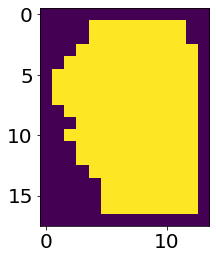

In [ ]:
print(np.shape(targets[5]))
plt.imshow(targets[5][...,1])

(17, 13, 2)


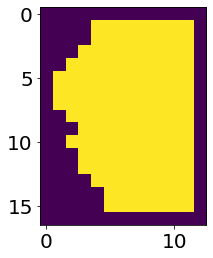

In [ ]:
print(np.shape(targets[5]))
plt.imshow(targets[5][...,1])

## cellular automata

In [ ]:
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
IDX=0
target, coord, mask, this_seed = targets[IDX], coords[IDX], masks[IDX], seeds[IDX]

In [ ]:
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
# prepare seed
height, width, _ = np.shape(target)
seed = np.zeros([1, height, width, num_channels], np.float32)
for i in range(num_channels-1):
  seed[:,..., i+1] = this_seed
# initialize model
model = ca_model_perception_clamp(device = device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
model_str = correct_label_in_plot(model)
# Preparing the seed pool
target0 = target
pool_size = 1024
seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
losses = []
# train automata
target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
start = time()
alive_masks = []
mask_diffs = []
inner_iter2 = 0
for i in range(epochs):
  ##
  if i < 100:
    inner_iter = 100
  elif i % 200 == 0: 
    inner_iter2 = inner_iter2 + 10
    inner_iter = np.min([inner_iter2, 100])

  scheduler.step()
  batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
  seed_batch = seed_pool[batch_idx].to(device)
  seed_batch[:1] = seed_tensor.to(device)
  
  loss, out, alive_mask, mask_diff = model.train_step(
      target = target_batch, 
      target_loss_func = F.mse_loss, 
      iters = inner_iter,
      seed = seed_batch,
      current_epoch = i,
      masked_loss = False
      )
  
  mask_diffs.append(mask_diff)
  alive_masks.append(alive_mask)

  seed_pool[batch_idx] = out.detach().to(device)
  loss.backward() # calculate gradients
  model.normalize_grads() # normalize them
  optimizer.step() # update weights and biases 
  optimizer.zero_grad() # prevent accumulation of gradients
  losses.append(loss.item())
  #early-stopping
  if loss.item() < 1e-5: break

  if i % 50==0 or i  == epochs-1:
    model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

stop = time()
time_total = f'{(stop-start)/60:.1f} mins'
print(time_total)
model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure

#lesion synthesis
x = torch.tensor(seed).permute(0,-1,1,2).to(device)
outs = []
with torch.no_grad():
  for i,special_sequence in zip(range(256),[1,1,1,3]*64):
    # x = model(x,special_sequence,101)
    x, alive_mask_, mask_diff_ = model(x,i,101)
    # x = model(x,i,i)
    out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
    outs.append(out)

#save results    
outs_masked = []
for out_ in outs:
    out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
    out_masked[out_masked==1]=0
    outs_masked.append(out_masked)
outs_int = np.asarray(outs_masked)
print(np.shape(outs_int))
outs_int = np.clip(outs_int, 0 ,1)
outs_int = (outs_int*255).astype('int16')
print(idx_lesion)

In [ ]:
np.shape(mask_diffs), 
fig, ax = plt.subplots(2,1)
ax[0].imshow(alive_masks[0][0,0,...])
ax[1].imshow(mask_diffs[0][0,0,...])

In [ ]:
for i in range(10):
  m_alive, m_diff = alive_masks[i], mask_diffs[i]
  fig, ax = plt.subplots(2,1)
  ax[0].imshow(m_alive[0,0,...])
  ax[1].imshow(m_diff[0,0,...])
  for axx in ax.ravel(): axx.axis('off')

In [ ]:
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

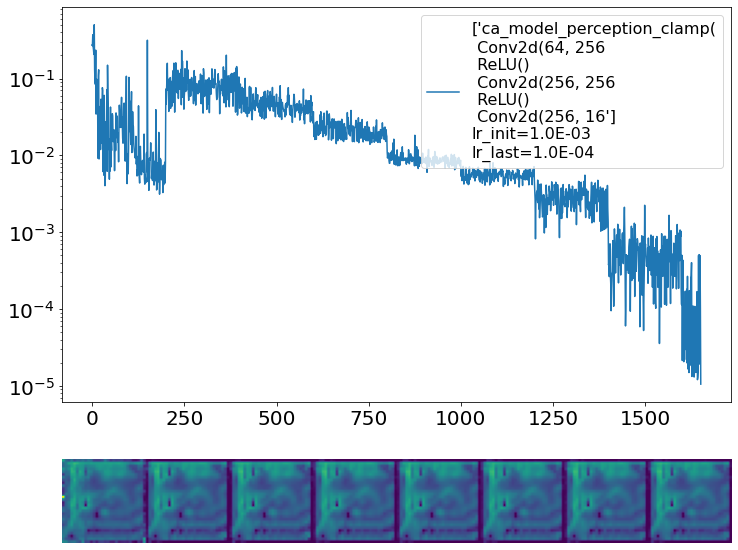

1650 1.054666154232109e-05
6.2 mins
(256, 30, 30)
15


In [ ]:
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion<12:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_perception_clamp(device = device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient04/'
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

In [ ]:
for i in np.arange(1,16,1):
  print(i)

NameError: ignored